# Contrastive Regression Model

### Load dataset from Kaggle

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from CustomDataset import AugmentedDataset, NonAugmentedDataset
from Layers.Residual import ResidualBlock, ResidualEncoder

In [4]:
# Download latest version
path = kagglehub.dataset_download("juanda220485/synthetic-dataset-of-speckle-images")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


### Transform model as Dataloader

In [34]:
non_aug_dataset = NonAugmentedDataset(path, transform=torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=[-90, 90]),
    lambda x: x + torch.randn_like(x) * 0.2,  # Add Gaussian noise
    lambda x: torch.clamp(x, 0.0, 1.0)  # Clip the values to be between 0 and 1
]))
#aug_dataset     = AugmentedDataset('./dataset_aug')
aug_dataset     = non_aug_dataset   # just for now, since extracting aug_dataset might take awhile

### View some images of the dataset

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tsope\AppData\Local\Temp\ipykernel_21820\3551002649.py:7: SyntaxWarning: invalid escape sequence '\d'
  plt.title(f"{temperature.item():.1f}$\degree$ C")


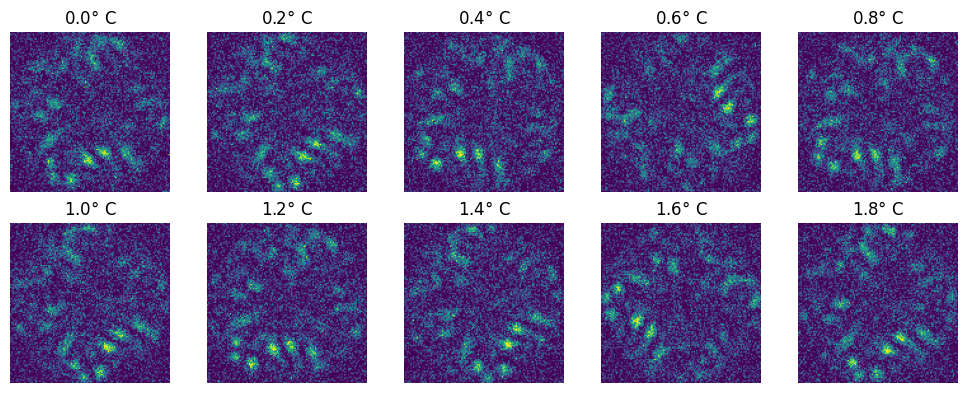

In [35]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    image_tensor, temperature = aug_dataset[i]
    image_np = image_tensor.numpy().squeeze()
    img=plt.imshow(image_np)
    plt.title(f"{temperature.item():.1f}$\degree$ C")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Define Model

In [ ]:
# Create a DataLoader
batch_size = 16
# Get the total size of the dataset
dataset_size = len(aug_dataset)

# Calculate sizes for training and validation splits
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

# Perform the split
train_dataset, val_dataset = random_split(aug_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SupervisedContrastiveRegression(nn.Module):
    def __init__(self, feature_dim=128, device : str = "cuda"):
        super(SupervisedContrastiveRegression, self).__init__()
        # Encoder: Feature extractor (e.g., CNN)
        self.encoder = ResidualEncoder(ResidualBlock, [2, 2, 2, 2]).to(device)  # ResNet-18 architecture

        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 192),
            nn.ReLU(),
            nn.Linear(192, feature_dim)
        ).to(device)
        
        # Regression head for temperature prediction
        self.regression_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)
    
    def forward(self, x):
        features = self.encoder(x)  # encoder
        contrastive_latent = self.projection_head(features)  # Projection head
        regression_output = self.regression_head(contrastive_latent)  # Regression head
        return contrastive_latent, regression_output

In [27]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, embeddings, targets):
        # Normalize embeddings to unit vectors
        embeddings = F.normalize(embeddings, p=2, dim=-1)
        
        # Compute the pairwise cosine similarity between embeddings
        cosine_sim = torch.matmul(embeddings, embeddings.T)
        
        # Mask out the diagonal (self-similarity)
        mask = torch.eye(cosine_sim.size(0), device=cosine_sim.device).bool()
        cosine_sim = cosine_sim[~mask].view(cosine_sim.size(0), -1)
        
        # Compute the target pairwise distances (absolute difference of targets)
        targets = targets.unsqueeze(0) - targets.unsqueeze(1)
        target_distances = torch.abs(targets)
        
        # Contrastive loss: pull similar targets closer and push dissimilar targets apart
        positive_mask = target_distances < target_distances.median()  # Similar targets (lower distance)
        negative_mask = ~positive_mask  # Dissimilar targets (higher distance)
        
        # Ensure that the positive/negative masks have the same shape as cosine_sim
        positive_mask = positive_mask[~mask].view(cosine_sim.size(0), -1)
        negative_mask = negative_mask[~mask].view(cosine_sim.size(0), -1)
        
        # Contrastive loss function (with temperature)
        positive_sim = cosine_sim[positive_mask]
        negative_sim = cosine_sim[negative_mask]
        
        loss_pos = -torch.log(torch.exp(positive_sim / self.temperature).sum(dim=0) / (positive_sim.size(0)))
        loss_neg = -torch.log(torch.exp(negative_sim / self.temperature).sum(dim=0) / (negative_sim.size(0)))
        
        loss = (loss_pos + loss_neg).mean()
        
        return loss
    

In [28]:
# Instantiate model, loss, and optimizer
model = SupervisedContrastiveRegression(feature_dim=128)
contrastive_loss_fn = SupervisedContrastiveLoss(temperature=0.1)
regression_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 32
device = "cuda"

# Function to calculate metrics
def calculate_metrics(predictions, targets):
    # Ensure predictions and targets are flattened to 1D arrays
    predictions = predictions.detach().cpu().numpy().flatten()
    targets = targets.detach().cpu().numpy().flatten()
    
    # Check that they are collections
    if predictions.size == 1 or targets.size == 1:
        raise ValueError("Both predictions and targets must contain multiple samples.")
    
    # Calculate metrics
    mae = np.mean(np.abs(predictions - targets))  # Mean Absolute Error
    mse = np.mean((predictions - targets)**2)    # Mean Squared Error
    r2 = r2_score(targets, predictions)          # R^2 Score
    
    return mae, mse, r2

# Training loop with metrics
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    mae_total, mse_total, r2_total = 0, 0, 0
    
    for images, temperatures in train_loader:  # Assuming DataLoader is defined
        images, temperatures = images.to(device), temperatures.to(device)

        # Forward pass
        contrastive_latent, regression_output = model(images)

        temperatures      = temperatures.view(-1)  # Ensure 1D array
        regression_output = regression_output.squeeze()
        
        # Compute losses
        contrastive_loss = contrastive_loss_fn(contrastive_latent, temperatures)
        regression_loss = regression_loss_fn(regression_output, temperatures)
        
        # Combine losses (weighted sum)
        loss = contrastive_loss + regression_loss
        
        
        # Compute loss
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        regression_loss.backward()
        optimizer.step()
        
        # Metrics
        mae, mse, r2 = calculate_metrics(regression_output, temperatures)
        mae_total += mae
        mse_total += mse
        r2_total += r2
    
    mae_avg = mae_total / len(train_loader)
    mse_avg = mse_total / len(train_loader)
    r2_avg = r2_total / len(train_loader)
    
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}, MAE: {mae_avg:.4f}, MSE: {mse_avg:.4f}, R^2: {r2_avg:.4f}")

Epoch 1, Loss: 1375.9332, MAE: 26.2888, MSE: 1395.7380, R^2: -0.1714
Epoch 2, Loss: 126.2369, MAE: 9.8931, MSE: 146.2244, R^2: 0.8637
Epoch 3, Loss: 102.1900, MAE: 8.3144, MSE: 122.1798, R^2: 0.8173
Epoch 4, Loss: 219.4591, MAE: 12.0217, MSE: 239.4461, R^2: 0.7721
Epoch 5, Loss: 143.9591, MAE: 10.1398, MSE: 163.9452, R^2: 0.8452
Epoch 6, Loss: 113.4861, MAE: 8.8804, MSE: 133.4689, R^2: 0.8685
Epoch 7, Loss: 76.6868, MAE: 8.0877, MSE: 96.6716, R^2: 0.9038
Epoch 8, Loss: 106.1171, MAE: 8.8245, MSE: 126.0926, R^2: 0.8766
Epoch 9, Loss: 78.5364, MAE: 7.9663, MSE: 98.5167, R^2: 0.9106
Epoch 10, Loss: 76.5300, MAE: 7.5438, MSE: 96.4950, R^2: 0.9061
Epoch 11, Loss: 98.0568, MAE: 8.6242, MSE: 118.0265, R^2: 0.8843
Epoch 12, Loss: 65.5242, MAE: 7.2418, MSE: 85.4837, R^2: 0.9206
Epoch 13, Loss: 98.9679, MAE: 8.6287, MSE: 118.9379, R^2: 0.8655
Epoch 14, Loss: 91.7971, MAE: 8.0789, MSE: 111.7600, R^2: 0.8923
Epoch 15, Loss: 142.7990, MAE: 9.7113, MSE: 162.7697, R^2: 0.8440
Epoch 16, Loss: 67.4251,

In [30]:
# Set the model to evaluation mode
model.eval()

# Store predictions and true values
predictions = []
true_temperatures = []

# Disable gradient calculation for inference
mae_total = 0
mse_total = 0
r2_total  = 0

with torch.no_grad():
    for images, temperatures in val_loader:
        # Move data to the appropriate device
        images = images.to(device)
        temperatures = temperatures.to(device)
        
        # Forward pass to predict temperatures
        _, predicted_temperatures = model(images)
        
        # Store predictions and true values
        predictions.append(predicted_temperatures.cpu().numpy())
        true_temperatures.append(temperatures.cpu().numpy())

        mae, mse, r2 = calculate_metrics(predicted_temperatures, temperatures)
        mae_total += mae
        mse_total += mse
        r2_total += r2

    mae_avg = mae_total / len(val_loader)
    mse_avg = mse_total / len(val_loader)
    r2_avg = r2_total / len(val_loader)

# Convert lists to numpy arrays for analysis
predictions = np.concatenate(predictions, axis=0)
true_temperatures = np.concatenate(true_temperatures, axis=0)

print(f"Predicted Temperatures: {predictions.flatten()[:5]}")
print(f"True Temperatures: {true_temperatures.flatten()[:5]}")
print(f"MAE: {mae_avg:.4f}, MSE: {mse_avg:.4f}, R^2: {r2_avg:.4f}")

Predicted Temperatures: [60.693848 27.73363  22.630047 16.550982 55.357574]
True Temperatures: [58.6 25.8 22.6 15.4 55.2]
MAE: 3.6439, MSE: 23.1766, R^2: 0.9791


### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

X_train, y_train = [], []
for images, temperatures in train_loader:
    # Flatten images and collect data
    X_train.append(images.view(images.size(0), -1).numpy())
    y_train.append(temperatures.numpy())

# Concatenate all collected batches into a single dataset
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate on validation set
X_val, y_val = [], []
for images, temperatures in val_loader:
    # Flatten images and collect data
    X_val.append(images.view(images.size(0), -1).numpy())
    y_val.append(temperatures.numpy())

# Concatenate validation data
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

# Make predictions
y_pred = lr_model.predict(X_val)

# Evaluate performance
r2 = r2_score(y_val, y_pred)
print(f"Validation R^2 Score: {r2:.4f}")

# Example predictions
print("True temperatures:", y_val[:5])
print("Predicted temperatures:", y_pred[:5])

Validation R^2 Score: 0.9745
True temperatures: [58.6 25.8 22.6 15.4 55.2]
Predicted temperatures: [60.752056 27.869095 26.208923 21.21019  55.582   ]
